In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import string 
string.punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df_train=pd.read_csv('../input/nlp-getting-started/train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test=pd.read_csv('../input/nlp-getting-started/test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_sample=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
df_sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## Date preprocessing

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

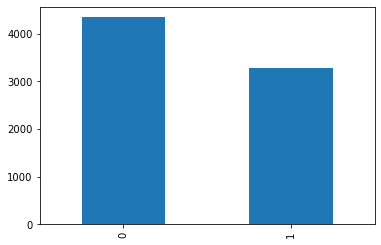

In [8]:
df_train['target'].value_counts().plot(kind='bar')

In [9]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
df_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [11]:
df_train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [12]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


### Clean the text

In [13]:
def tweets_cleaning(text):
    lowercase = text.lower()
    punc_removal = [char for char in lowercase if char not in string.punctuation]
    punc_removal_joined = ''.join(punc_removal)
    url_removal = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', punc_removal_joined, flags=re.MULTILINE)
    emoji_removal = url_removal.encode('ascii', 'ignore').decode('ascii')
    stopwords_removal = [word for word in emoji_removal.split() if word not in stopwords.words('english')]
    return stopwords_removal

In [14]:
df_train['cleaned_text']=df_train['text'].apply(tweets_cleaning).astype(str)

In [15]:
df_test['cleaned_text']=df_test['text'].apply(tweets_cleaning).astype(str)

In [16]:
df_train.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"['deeds', 'reason', 'earthquake', 'may', 'alla..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"['forest', 'fire', 'near', 'la', 'ronge', 'sas..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"['residents', 'asked', 'shelter', 'place', 'no..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"['13000', 'people', 'receive', 'wildfires', 'e..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"['got', 'sent', 'photo', 'ruby', 'alaska', 'sm..."


In [17]:
df_train_clean=df_train[['cleaned_text','target']]

In [18]:
df_train_clean.head()

,cleaned_text,target
0,"['deeds', 'reason', 'earthquake', 'may', 'alla...",1
1,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...",1
2,"['residents', 'asked', 'shelter', 'place', 'no...",1
3,"['13000', 'people', 'receive', 'wildfires', 'e...",1
4,"['got', 'sent', 'photo', 'ruby', 'alaska', 'sm...",1


### Tokenization

In [19]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df_train_clean['cleaned_text'].values)
X = tokenizer.texts_to_sequences(df_train_clean['cleaned_text'].values)
X = pad_sequences(X)

## LSTM Model training

In [20]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 18, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
Y = pd.get_dummies(df_train_clean['target']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5100, 18) (5100, 2)
(2513, 18) (2513, 2)


In [22]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
160/160 - 10s - loss: 0.5576 - accuracy: 0.7155
Epoch 2/7
160/160 - 11s - loss: 0.3889 - accuracy: 0.8294
Epoch 3/7
160/160 - 10s - loss: 0.3453 - accuracy: 0.8533
Epoch 4/7
160/160 - 10s - loss: 0.3052 - accuracy: 0.8694
Epoch 5/7
160/160 - 10s - loss: 0.2680 - accuracy: 0.8888
Epoch 6/7
160/160 - 10s - loss: 0.2419 - accuracy: 0.8967
Epoch 7/7
160/160 - 10s - loss: 0.2166 - accuracy: 0.9104


## Predictions

In [23]:
df_test.head()

,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,"['happened', 'terrible', 'car', 'crash']"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","['heard', 'earthquake', 'different', 'cities',..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","['forest', 'fire', 'spot', 'pond', 'geese', 'f..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"['apocalypse', 'lighting', 'spokane', 'wildfir..."
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"['typhoon', 'soudelor', 'kills', '28', 'china'..."


In [24]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df_test['cleaned_text'].values)
X = tokenizer.texts_to_sequences(df_test['cleaned_text'].values)
X = pad_sequences(X)

In [25]:
pred=model.predict(X)

In [26]:
labels=[0,1]

In [27]:
pred.shape

(3263, 2)

In [28]:
pred

array([[0.0179459 , 0.9820541 ],
       [0.79368687, 0.20631313],
       [0.8063105 , 0.19368953],
       ...,
       [0.36379153, 0.6362084 ],
       [0.00223738, 0.99776256],
       [0.9075838 , 0.09241628]], dtype=float32)

In [29]:
df_sub=pd.DataFrame()

In [30]:
tweet_predict=[]

In [31]:
df_test.head()

,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,"['happened', 'terrible', 'car', 'crash']"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","['heard', 'earthquake', 'different', 'cities',..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","['forest', 'fire', 'spot', 'pond', 'geese', 'f..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"['apocalypse', 'lighting', 'spokane', 'wildfir..."
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"['typhoon', 'soudelor', 'kills', '28', 'china'..."


In [32]:
df_test['id'][0]

0

In [33]:
idx=0
for p in pred:
    predict=[]
    t_id=df_test['id'][idx]
    idx+=1
    target=labels[np.argmax(p)]
    predict.append(t_id)
    predict.append(target)
    tweet_predict.append(predict)
    

In [34]:
df_sub=pd.DataFrame(tweet_predict,columns=["id","target"])

In [35]:
df_sub.head()

,id,target
0,0,1
1,2,0
2,3,0
3,9,0
4,11,0


In [36]:
df_sub.to_csv('submission.csv',index=False)